In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#import spacy
from torchtext.legacy.data import Field, BucketIterator
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
class TransformerClassifier(torch.nn.Module):

    def __init__(self, src_pad_idx, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super(TransformerClassifier, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.encoder = Encoder(enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device)
        self.linear = nn.Linear(d_model * max_len, 2).to(device)

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def forward(self, x):
        mask = self.make_pad_mask(x, x)
        x = self.encoder(x, mask)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [5]:
def plot_training(history, marker=None):
  plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training loss')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_loss'] + history['val_loss'])
    y_max = max(history['train_loss'] + history['val_loss'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'])
  plt.plot(history['val_acc'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training metric')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_acc'] + history['val_acc'])
    y_max = max(history['train_acc'] + history['val_acc'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.show()

In [6]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

          # save best model (w.r.t validation loss)
          if val_loss < best_model_score:
            best_model = model.state_dict()
            best_model_score = val_loss
            best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
data = pd.concat([pd.read_csv("./Data/SMS_train.csv", encoding='ISO-8859-1'),
                  pd.read_csv("./Data/SMS_test.csv", encoding='ISO-8859-1')])

# convert string label to binary (int) label (spam:1, non-spam:0)
labels = pd.Series((data['Label'] == 'Spam').astype(int))
data['Label'] = labels

# train, test, val split
train, valid, test = loader.make_dataset(data[['Message_body', 'Label']])
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=128,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
1
Message_body    [[CLS], free, ##ms, ##g, hey, there, darling, ...
Label                                                           1
len                                                           147
Name: 64, dtype: object


100%|██████████| 108/108 [00:00<00:00, 11370.10it/s]

dataset initializing done
Vocabulary Size :  2707


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

In [ ]:
%%time
# train model A
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optA = torch.optim.SGD(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 200

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)
torch.save(best_modelA, './Models/modelA')

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:05<00:00,  9.42s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8651               Validation Loss: 0.4721               Train acc: 0.4707,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 2  Train Loss: 0.4605               Validation Loss: 0.4478               Train acc: 0.8196,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Epoch: 3  Train Loss: 0.4299               Validation Loss: 0.4156               Train acc: 0.8221,               Val acc: 0.8224


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 4  Train Loss: 0.4082               Validation Loss: 0.4067               Train acc: 0.8210,               Val acc: 0.8224


 71%|███████▏  | 5/7 [00:35<00:14,  7.25s/it]

In [ ]:
%%time
# train model B
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optB = torch.optim.SGD(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 200

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)
torch.save(best_modelB, './Models/modelB')

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-117-65484155935c>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:32<00:00, 13.24s/it]
<ipython-input-117-65484155935c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.5818               Validation Loss: 0.4648               Train acc: 0.6871,               Val acc: 0.8224


 14%|█▍        | 1/7 [00:25<02:32, 25.49s/it]


KeyboardInterrupt: ignored

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = 2707, # TODO: make arbitrary
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = 2707,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = 2707,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

<All keys matched successfully>

### Fusion

In [5]:
model_fusion = vanilla_fusion(modelA, modelB)

NameError: name 'vanilla_fusion' is not defined

### Test fusion

<ipython-input-117-65484155935c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


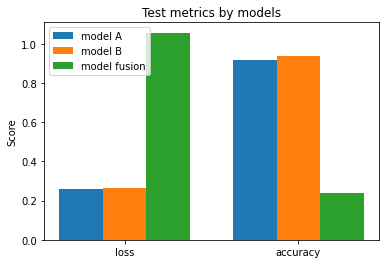

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = 2707,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

<ipython-input-117-65484155935c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


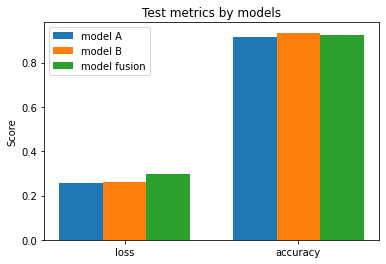

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-117-65484155935c>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:46<00:00, 15.28s/it]
<ipython-input-117-65484155935c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.2515               Validation Loss: 0.2681               Train acc: 0.9255,               Val acc: 0.8505


100%|██████████| 7/7 [01:27<00:00, 12.48s/it]


Epoch: 2  Train Loss: 0.2259               Validation Loss: 0.2672               Train acc: 0.9390,               Val acc: 0.8692


100%|██████████| 7/7 [01:25<00:00, 12.18s/it]


Epoch: 3  Train Loss: 0.2249               Validation Loss: 0.2659               Train acc: 0.9527,               Val acc: 0.8411


100%|██████████| 7/7 [01:31<00:00, 13.07s/it]


Epoch: 4  Train Loss: 0.2244               Validation Loss: 0.2653               Train acc: 0.9390,               Val acc: 0.8598


100%|██████████| 7/7 [01:24<00:00, 12.09s/it]


Epoch: 5  Train Loss: 0.2191               Validation Loss: 0.2596               Train acc: 0.9538,               Val acc: 0.8505


100%|██████████| 7/7 [01:26<00:00, 12.41s/it]


Epoch: 6  Train Loss: 0.2162               Validation Loss: 0.2570               Train acc: 0.9466,               Val acc: 0.8598


100%|██████████| 7/7 [01:24<00:00, 12.11s/it]


Epoch: 7  Train Loss: 0.2127               Validation Loss: 0.2546               Train acc: 0.9521,               Val acc: 0.8598


100%|██████████| 7/7 [01:26<00:00, 12.40s/it]


Epoch: 8  Train Loss: 0.2115               Validation Loss: 0.2552               Train acc: 0.9483,               Val acc: 0.8505


100%|██████████| 7/7 [01:24<00:00, 12.10s/it]


Epoch: 9  Train Loss: 0.2147               Validation Loss: 0.2569               Train acc: 0.9315,               Val acc: 0.8505


100%|██████████| 7/7 [01:26<00:00, 12.43s/it]


Epoch: 10  Train Loss: 0.2077               Validation Loss: 0.2510               Train acc: 0.9511,               Val acc: 0.8505


100%|██████████| 7/7 [01:24<00:00, 12.12s/it]


Epoch: 11  Train Loss: 0.2080               Validation Loss: 0.2496               Train acc: 0.9440,               Val acc: 0.8879


100%|██████████| 7/7 [01:24<00:00, 12.11s/it]


Epoch: 12  Train Loss: 0.2084               Validation Loss: 0.2483               Train acc: 0.9538,               Val acc: 0.8692


100%|██████████| 7/7 [01:27<00:00, 12.44s/it]


Epoch: 13  Train Loss: 0.2021               Validation Loss: 0.2645               Train acc: 0.9501,               Val acc: 0.8411


100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


Epoch: 14  Train Loss: 0.2070               Validation Loss: 0.2451               Train acc: 0.9437,               Val acc: 0.8598


100%|██████████| 7/7 [01:27<00:00, 12.45s/it]


Epoch: 15  Train Loss: 0.1980               Validation Loss: 0.2434               Train acc: 0.9594,               Val acc: 0.8598


100%|██████████| 7/7 [01:25<00:00, 12.15s/it]


Epoch: 16  Train Loss: 0.1973               Validation Loss: 0.2452               Train acc: 0.9517,               Val acc: 0.8879


100%|██████████| 7/7 [01:26<00:00, 12.42s/it]


Epoch: 17  Train Loss: 0.2015               Validation Loss: 0.2405               Train acc: 0.9449,               Val acc: 0.8692


100%|██████████| 7/7 [01:24<00:00, 12.14s/it]


Epoch: 18  Train Loss: 0.1963               Validation Loss: 0.2454               Train acc: 0.9523,               Val acc: 0.9065


100%|██████████| 7/7 [01:25<00:00, 12.24s/it]


Epoch: 19  Train Loss: 0.1968               Validation Loss: 0.2477               Train acc: 0.9661,               Val acc: 0.8505


100%|██████████| 7/7 [01:24<00:00, 12.13s/it]


Epoch: 20  Train Loss: 0.1928               Validation Loss: 0.2384               Train acc: 0.9534,               Val acc: 0.8505


100%|██████████| 7/7 [01:24<00:00, 12.11s/it]


Epoch: 21  Train Loss: 0.1943               Validation Loss: 0.2489               Train acc: 0.9524,               Val acc: 0.8879


100%|██████████| 7/7 [01:27<00:00, 12.44s/it]


Epoch: 22  Train Loss: 0.1957               Validation Loss: 0.2369               Train acc: 0.9623,               Val acc: 0.8598


100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


Epoch: 23  Train Loss: 0.1890               Validation Loss: 0.2363               Train acc: 0.9534,               Val acc: 0.8692


100%|██████████| 7/7 [01:27<00:00, 12.50s/it]


Epoch: 24  Train Loss: 0.1948               Validation Loss: 0.2352               Train acc: 0.9517,               Val acc: 0.8785


100%|██████████| 7/7 [01:25<00:00, 12.27s/it]


Epoch: 25  Train Loss: 0.1876               Validation Loss: 0.2376               Train acc: 0.9588,               Val acc: 0.8785


100%|██████████| 7/7 [01:28<00:00, 12.59s/it]


Epoch: 26  Train Loss: 0.1883               Validation Loss: 0.2389               Train acc: 0.9561,               Val acc: 0.8692


100%|██████████| 7/7 [01:25<00:00, 12.28s/it]


Epoch: 27  Train Loss: 0.1867               Validation Loss: 0.2341               Train acc: 0.9600,               Val acc: 0.8692


100%|██████████| 7/7 [01:27<00:00, 12.56s/it]


Epoch: 28  Train Loss: 0.1861               Validation Loss: 0.2367               Train acc: 0.9640,               Val acc: 0.8972


100%|██████████| 7/7 [01:25<00:00, 12.23s/it]


Epoch: 29  Train Loss: 0.1895               Validation Loss: 0.2336               Train acc: 0.9589,               Val acc: 0.8692


100%|██████████| 7/7 [01:25<00:00, 12.25s/it]


Epoch: 30  Train Loss: 0.1824               Validation Loss: 0.2476               Train acc: 0.9578,               Val acc: 0.8505


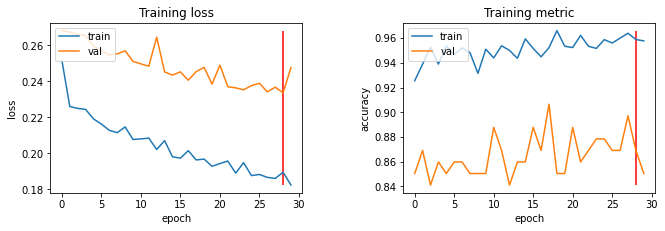

CPU times: user 44min 11s, sys: 58.7 s, total: 45min 10s
Wall time: 45min 19s


In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 30
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
model_fusion.load_state_dict(best_model_fusion)

<All keys matched successfully>

### Test fusion (after retraining)

<ipython-input-117-65484155935c>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


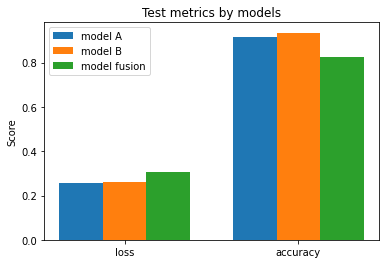

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)